In [40]:
# import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score,KFold
from sklearn.svm import LinearSVC, SVC
from mlxtend.plotting import plot_decision_regions
import statsmodels.api as sm
from scipy.ndimage.measurements import mean
from sklearn.preprocessing import StandardScaler
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore') #ignore warning messages

In [37]:
# Define cross-validation metrics
def cross_val_metrics(model, X, y) :
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = ['f1','accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = kf, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))


#Define output results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def test_network(clf, X_test, y_test):
  pred = clf.predict(X_test)
  clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
  print("Test Result:\n================================================")        
  print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{clf_report}")
  print("_______________________________________________")
  print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

# Data Loading

1. exclude space missing values and change the variable ‘BARE’ as integer.
2. change the ‘CLASS’ variable into 0 and 1 as a cancer signal

In [24]:
from google.colab import drive
drive.mount('/content/drive')
# Read training data
train_data = pd.read_csv("/content/drive/MyDrive/Data/BREAST-CANCER-TRAIN-R.csv")
# Drop the ID feature
train_data = train_data.drop('ID', 1)
# Remove space
train_data = train_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
print(train_data.isnull().sum())
modifiedDf = train_data.dropna() # Remove rows with empty values
print(modifiedDf.isnull().sum())
modifiedDf.dtypes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CLUMP          0
CELL_SIZE      0
CELL_SHAPE     0
ADHESION       0
EPITHELIAL     0
BARE          11
BLAND          0
NORMAL         0
MITOSIS        0
CLASS          0
dtype: int64
CLUMP         0
CELL_SIZE     0
CELL_SHAPE    0
ADHESION      0
EPITHELIAL    0
BARE          0
BLAND         0
NORMAL        0
MITOSIS       0
CLASS         0
dtype: int64


CLUMP          int64
CELL_SIZE      int64
CELL_SHAPE     int64
ADHESION       int64
EPITHELIAL     int64
BARE          object
BLAND          int64
NORMAL         int64
MITOSIS        int64
CLASS          int64
dtype: object

In [25]:
modifiedDf['BARE'] = pd.to_numeric(modifiedDf['BARE'])
modifiedDf.dtypes
modifiedDf.shape

(406, 10)

In [26]:
modifiedDf['CLASS'].replace(2,0,inplace = True)
modifiedDf['CLASS'].replace(4,1,inplace = True)
modifiedDf[['CLASS']].head()

,CLASS
0,0
1,0
2,0
3,0
4,0


# Descriptive Analysis and Visualization


In [27]:
modifiedDf.describe()

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS,CLASS
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,4.384236,3.197044,3.229064,2.773399,3.290640,3.539409,3.502463,2.889163,1.674877,0.349754
std,2.769347,3.087304,3.004399,2.790262,2.245272,3.653130,2.445201,3.081611,1.886328,0.477480
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,3.000000,4.000000,5.750000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [28]:
modifiedDf.groupby("CLASS").mean()

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS
CLASS,,,,,,,,,
0,2.950758,1.344697,1.420455,1.318182,2.136364,1.382576,2.121212,1.265152,1.056818
1,7.049296,6.640845,6.591549,5.478873,5.436620,7.549296,6.070423,5.908451,2.823944


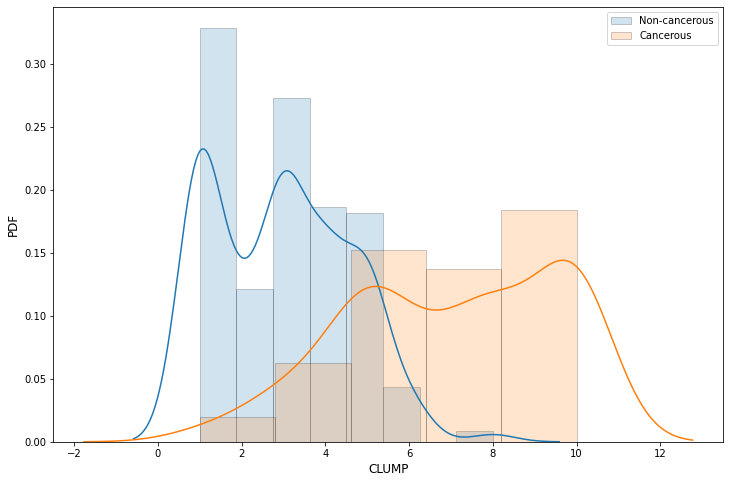

In [29]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(modifiedDf[modifiedDf['CLASS']==0]['CLUMP'],
            label = 'Non-cancerous', ax=ax, hist_kws = hist_kws)
sns.distplot(modifiedDf[modifiedDf['CLASS']==1]['CLUMP'],
            label = 'Cancerous', ax=ax, hist_kws = hist_kws)
ax.set_xlabel('CLUMP', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

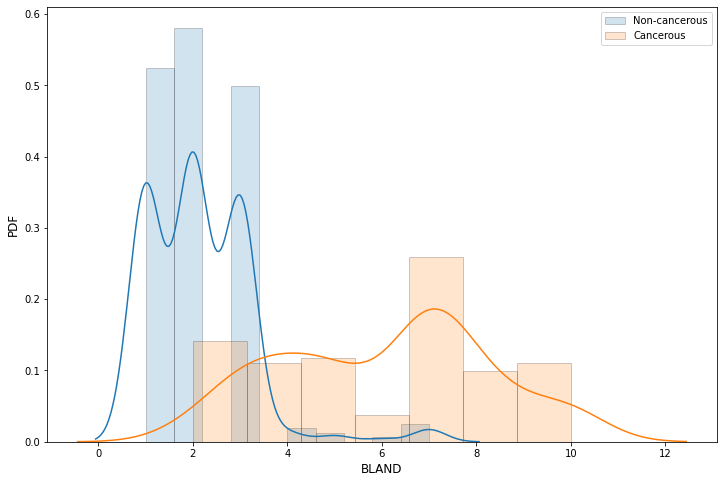

In [30]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(modifiedDf[modifiedDf['CLASS']==0]['BLAND'],
            label = 'Non-cancerous', ax=ax, hist_kws = hist_kws)
sns.distplot(modifiedDf[modifiedDf['CLASS']==1]['BLAND'],
            label = 'Cancerous', ax=ax, hist_kws = hist_kws)
ax.set_xlabel('BLAND', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

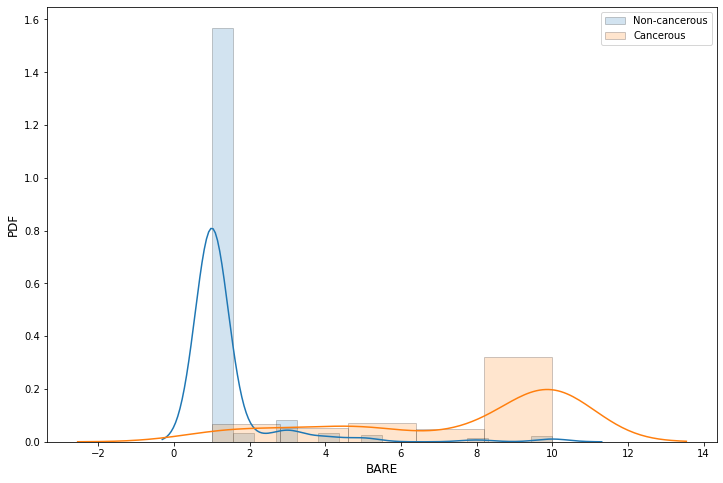

In [31]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(modifiedDf[modifiedDf['CLASS']==0]['BARE'],
            label = 'Non-cancerous', ax=ax, hist_kws = hist_kws)
sns.distplot(modifiedDf[modifiedDf['CLASS']==1]['BARE'],
            label = 'Cancerous', ax=ax, hist_kws = hist_kws)
ax.set_xlabel('BARE', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

# Data Processing

In [32]:
#Prepare train dataset
# Define X(features) and Y(diagnosis(0 or 1))
y_data = modifiedDf['CLASS']
x_data = modifiedDf.drop('CLASS', 1).reset_index(drop=True)
col = modifiedDf.columns
#Standardization
sc = StandardScaler()
x_data = sc.fit_transform(x_data)
x_data = pd.DataFrame(x_data,columns = col[:-1])
y_data.reset_index(drop= True,inplace = True)

exclude outliers by deleting absolute z-scores lager than 4

In [33]:
#exclude outliers 
join = pd.concat([x_data,y_data],axis = 1)
join = join[join['MITOSIS']<=4]
y_data = join['CLASS']
x_data = join.drop('CLASS', 1).reset_index(drop=True)
x_data.head()

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS
0,0.222624,-0.712516,-0.742849,-0.636351,-0.575535,-0.695990,-0.205743,-0.613800,-0.358214
1,0.222624,0.260404,0.256919,0.798974,1.654114,1.770691,-0.205743,-0.288894,-0.358214
2,0.584166,1.557631,1.589943,-0.636351,-0.129605,0.126237,-0.205743,1.335636,-0.358214
3,-0.138917,-0.712516,-0.742849,0.081312,-0.575535,-0.695990,-0.205743,-0.613800,-0.358214
4,-1.223542,-0.712516,-0.742849,-0.636351,-0.575535,1.770691,-0.205743,-0.613800,-0.358214


In [34]:
#Data collinearity test
variance_inflation_factor(x_data.values, 1)

7.694241775830329

VIF>5, there is severe multicollinearity. So cell shape is excluded in the next step


In [35]:
x_data_withoutshape = x_data.drop('CELL_SHAPE',1)
variance_inflation_factor(x_data_withoutshape.values, 1)

4.2550446985311545

single factor checking,
because the variables are not continuous, so it is hard to see the relationships directly from the pair plots. 

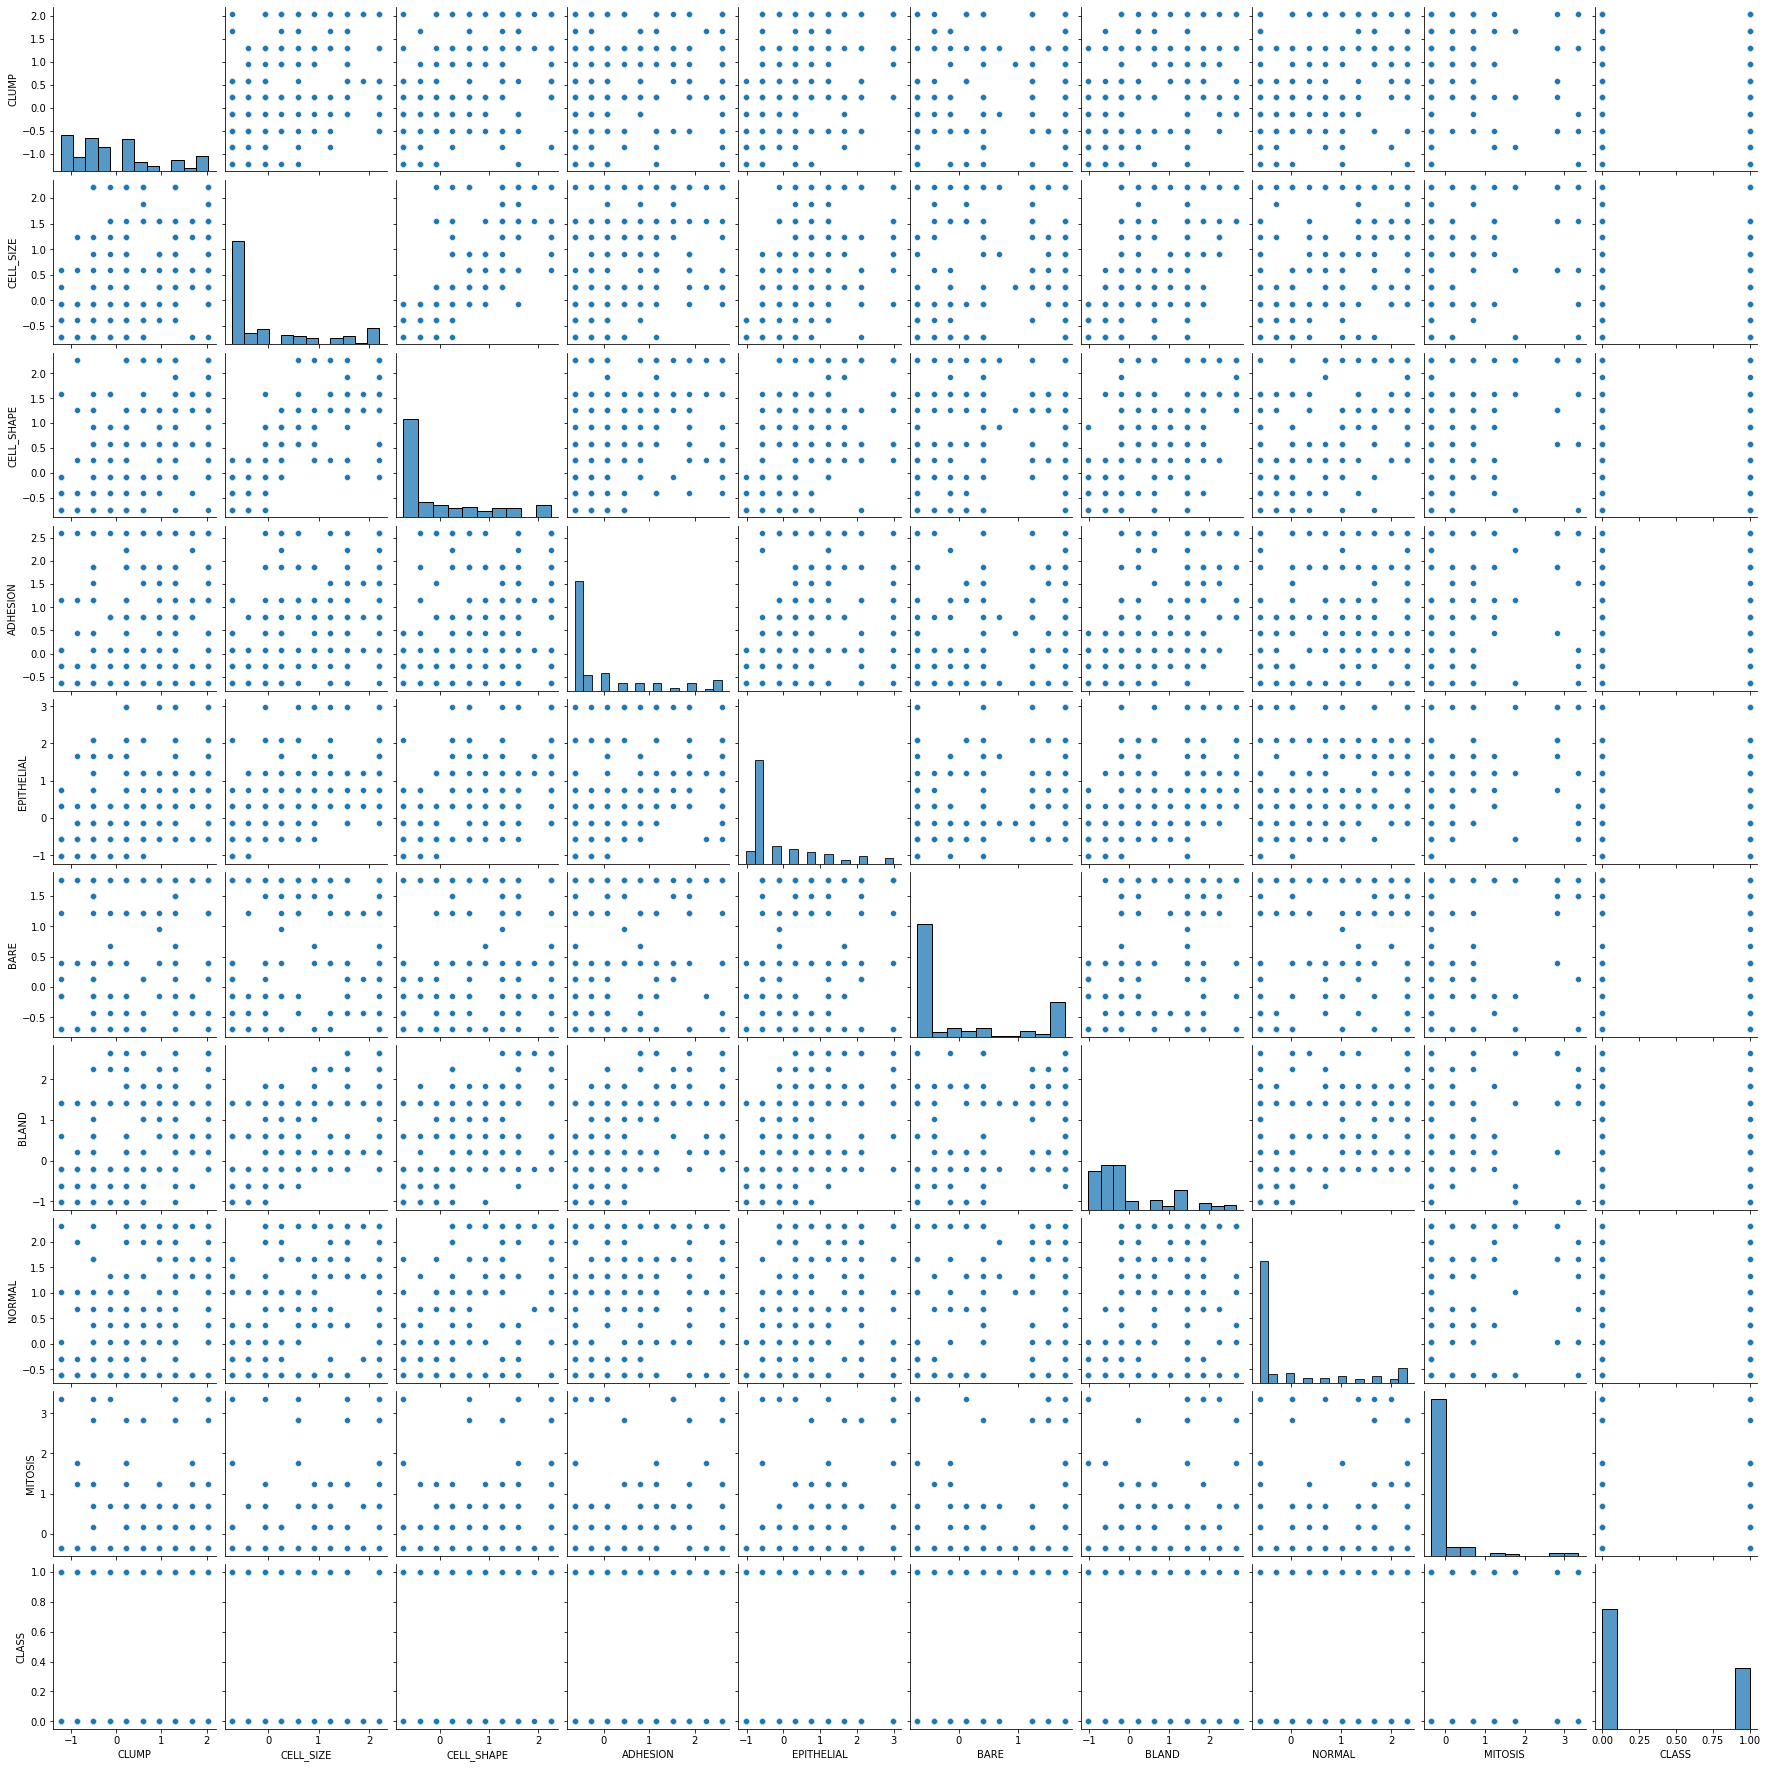

In [21]:
sns.pairplot(join)

# Modeling
For all models, use 5-fold cross validation

# Support Vector Machine

In [38]:
# Kfold validation on SVM model using all 9 features
linear_kernel_SVM1 = SVC(gamma='auto', kernel='linear', probability=True)
linear_kernel_SVM1.fit(x_data,y_data)
cross_val_metrics(linear_kernel_SVM1, x_data, y_data)

[f1] : 0.94572 (+/- 0.02141)
[accuracy] : 0.96206 (+/- 0.01795)
[precision] : 0.93862 (+/- 0.05483)
[recall] : 0.95602 (+/- 0.02701)


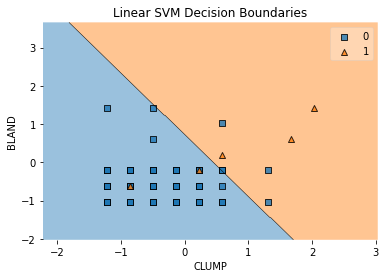

In [42]:
#Plotting Linear SVM decision boundaries with 2 features 
value = 0
width = 1
plot_decision_regions(np.array(x_data), np.array(y_data), clf=linear_kernel_SVM1, legend=1,
                      feature_index=[0,6], 
                      filler_feature_values ={1:value,2:value,3:value,4:value,5:value,7:value,8:value},
                      filler_feature_ranges = {1:width,2:width,3:width,4:width,5:width,7:width,8:width})
plt.xlabel('CLUMP')
plt.ylabel('BLAND')
plt.title('Linear SVM Decision Boundaries')
plt.show()

In [43]:
# Kfold validation on SVM model using 8 features(without cell_shape)
linear_kernel_SVM2 = SVC(gamma='auto', kernel='linear', probability=True)
linear_kernel_SVM2.fit(x_data_withoutshape,y_data)
cross_val_metrics(linear_kernel_SVM2, x_data_withoutshape, y_data)

[f1] : 0.94963 (+/- 0.02157)
[accuracy] : 0.96459 (+/- 0.01864)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.95602 (+/- 0.02701)


In [44]:
# Kfold validation on non-linear SVM model using all 9 features
param_grid = {'gamma':np.linspace(0.0001,1,20),
              'C': np.arange(0,2.5,0.25),
              'kernel':['rbf']}
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
svm_nonlinear1 = SVC(probability= True)
grid_svm_nonlinear1 = GridSearchCV(estimator = svm_nonlinear1, param_grid = param_grid,scoring = 'recall', cv=kf,
                    n_jobs = -1)
grid_svm_nonlinear1.fit(x_data, y_data)
best_parameters1 = grid_svm_nonlinear1.best_params_
best_scores1 = grid_svm_nonlinear1.best_score_
print('The best parameters for using this model is', best_parameters1)
print('The best scores for using this model is', best_scores1)

The best parameters for using this model is {'C': 0.25, 'gamma': 0.7894947368421052, 'kernel': 'rbf'}
The best scores for using this model is 0.99375


In [45]:
# Kfold validation on non-linear SVM model using 8 features(without cell_shape)
param_grid = {'gamma':np.linspace(0.0001,1,20),
              'C': np.arange(0,2.5,0.25),
              'kernel':['rbf']}
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
svm_nonlinear2 = SVC(probability= True)
grid_svm_nonlinear2 = GridSearchCV(estimator = svm_nonlinear2, param_grid = param_grid,scoring = 'recall', cv=kf,
                     n_jobs = -1)
grid_svm_nonlinear2.fit(x_data_withoutshape, y_data)
best_parameters2 = grid_svm_nonlinear2.best_params_
best_scores2 = grid_svm_nonlinear2.best_score_
print('The best parameters for using this model is', best_parameters2)
print('The best scores for using this model is', best_scores2)

The best parameters for using this model is {'C': 0.25, 'gamma': 0.7894947368421052, 'kernel': 'rbf'}
The best scores for using this model is 0.99375


In [46]:
# SVM Confusion matrix on all training data
svm = SVC(**grid_svm_nonlinear2.best_params_,probability= True)
svm.fit(x_data_withoutshape, y_data)
y_pred = svm.predict(x_data_withoutshape)
y_pred_probs = svm.predict_proba(x_data_withoutshape)[:,1]
cross_val_metrics(svm, x_data, y_data)

[f1] : 0.91595 (+/- 0.04885)
[accuracy] : 0.93674 (+/- 0.03759)
[precision] : 0.85335 (+/- 0.08346)
[recall] : 0.99375 (+/- 0.01250)


In [47]:
test_network(svm, x_data_withoutshape, y_data)

Test Result:
Accuracy Score: 94.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.851613  0.941919    0.925806      0.950538
recall       0.912879    1.000000  0.941919    0.956439      0.941919
f1-score     0.954455    0.919861  0.941919    0.937158      0.942924
support    264.000000  132.000000  0.941919  396.000000    396.000000
_______________________________________________
Confusion Matrix: 
 [[241  23]
 [  0 132]]



There is no obvious difference in terms of model performance between using all 9 features and 8 features(without cell_shape). In order to better comparing the other models, we use 8 features.
Compared with SVC model, SVM model has lower accuracy but higher recall(99.37%). In the breast cancer case, we think recall is more important  because we do not want misclassify any true malignant tumors.

# KNN

[0.9120476190476191, 0.8715424430641822, 0.9351904761904762, 0.9280476190476191, 0.9497738095238095, 0.9497738095238095, 0.9497738095238095, 0.9497738095238095, 0.9560238095238095, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763]
[0.9519620253164558, 0.9469620253164557, 0.9595569620253164, 0.9595569620253166, 0.967120253164557, 0.967120253164557, 0.967120253164557, 0.967120253164557, 0.9696518987341772, 0.9671518987341772, 0.

Text(0.5, 1.0, 'KNN1 on breast cancer data')

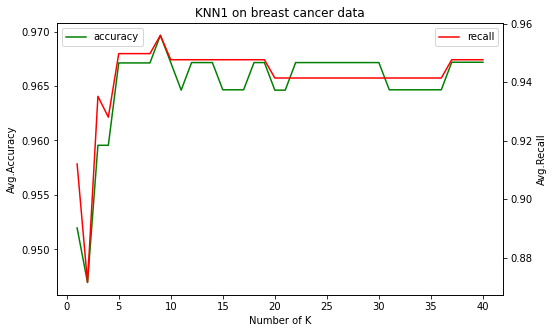

In [48]:
# Kfold validation on KNN model using all 9 features
from sklearn.neighbors import KNeighborsClassifier
recall = []
accuracy = []
for k in range(1,41):
  kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
  knn1 = KNeighborsClassifier(n_neighbors =k)
  knn1.fit(x_data, y_data)
  recall.append(cross_val_score(knn1, x_data, y_data, scoring='recall', cv=kf, n_jobs=-1).mean())
  accuracy.append(cross_val_score(knn1, x_data, y_data, scoring='accuracy', cv=kf, n_jobs=-1).mean())
print(recall)
print(accuracy)
print("Maximum accuracy:",max(accuracy),"at K =",accuracy.index(max(accuracy))+1)
print("Maximum recall:",max(recall),"at K =",recall.index(max(recall))+1)
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(range(1,41),accuracy,color = 'g',label = 'accuracy')
ax1.set_ylabel('Avg.Accuracy')
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.plot(range(1,41),recall,color = 'r',label = 'recall')
ax2.set_ylabel('Avg.Recall')
ax2.legend(loc = 'upper right')
ax1.set(xlabel = 'Number of K')
plt.title('KNN1 on breast cancer data')

[0.8971309523809523, 0.8645967908902691, 0.9289404761904763, 0.9217976190476191, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9414404761904762]
[0.9469620253164557, 0.9444303797468354, 0.9544936708860761, 0.9570253164556963, 0.9646202531645569, 0.9646202531645569, 0.9620886075949366, 0.9646202531645569, 0.9646202531645569, 0.9646202531645569

Text(0.5, 1.0, 'KNN2 on breast cancer data')

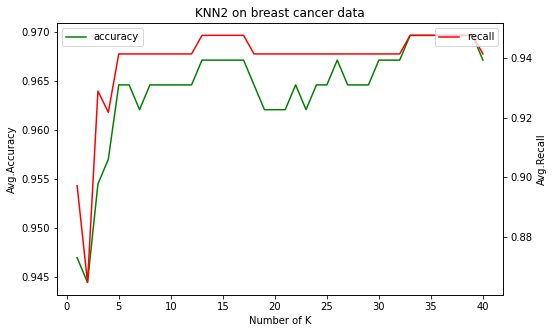

In [49]:
# Kfold validation on KNN model using 8 features
from sklearn.neighbors import KNeighborsClassifier
recall = []
accuracy = []
for k in range(1,41):
  kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
  knn2 = KNeighborsClassifier(n_neighbors =k)
  knn2.fit(x_data_withoutshape, y_data)
  recall.append(cross_val_score(knn2, x_data_withoutshape, y_data, scoring='recall', cv=kf, n_jobs=-1).mean())
  accuracy.append(cross_val_score(knn2, x_data_withoutshape, y_data, scoring='accuracy', cv=kf, n_jobs=-1).mean())
print(recall)
print(accuracy)
print("Maximum accuracy:",max(accuracy),"at K =",accuracy.index(max(accuracy))+1)
print("Maximum recall:",max(recall),"at K =",recall.index(max(recall))+1)
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(range(1,41),accuracy,color = 'g',label = 'accuracy')
ax1.set_ylabel('Avg.Accuracy')
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.plot(range(1,41),recall,color = 'r',label = 'recall')
ax2.set_ylabel('Avg.Recall')
ax2.legend(loc = 'upper right')
ax1.set(xlabel = 'Number of K')
plt.title('KNN2 on breast cancer data')

In [50]:
# KNN Confusion matrix on all training data
knn = KNeighborsClassifier(n_neighbors =9)
knn.fit(x_data, y_data)
cross_val_metrics(knn, x_data, y_data)

[f1] : 0.95686 (+/- 0.02000)
[accuracy] : 0.96965 (+/- 0.01720)
[precision] : 0.95917 (+/- 0.03822)
[recall] : 0.95602 (+/- 0.02701)


In [51]:
test_network(knn, x_data, y_data)

Test Result:
Accuracy Score: 97.22%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.980989    0.954887  0.972222    0.967938      0.972288
recall       0.977273    0.962121  0.972222    0.969697      0.972222
f1-score     0.979127    0.958491  0.972222    0.968809      0.972248
support    264.000000  132.000000  0.972222  396.000000    396.000000
_______________________________________________
Confusion Matrix: 
 [[258   6]
 [  5 127]]



#Logistic Regression

In [54]:
CV_log_clf = LogisticRegression()
CV_log_clf.fit(x_data_withoutshape, y_data)
cross_val_metrics(CV_log_clf, x_data_withoutshape, y_data)

[f1] : 0.94519 (+/- 0.01691)
[accuracy] : 0.96209 (+/- 0.01606)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.94769 (+/- 0.03113)


In [57]:
# use statsmodels to check the p value
y_data = pd.DataFrame(y_data)
y_data=y_data.reset_index(drop=True)
x_data_withoutshape1 = sm.add_constant(x_data_withoutshape)
log_reg = sm.Logit(y_data,x_data_withoutshape1)
clf_1 = log_reg.fit()
print(clf_1.summary())


Optimization terminated successfully.
         Current function value: 0.076270
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  CLASS   No. Observations:                  396
Model:                          Logit   Df Residuals:                      387
Method:                           MLE   Df Model:                            8
Date:                Mon, 02 Jan 2023   Pseudo R-squ.:                  0.8802
Time:                        04:57:35   Log-Likelihood:                -30.203
converged:                       True   LL-Null:                       -252.06
Covariance Type:            nonrobust   LLR p-value:                 8.218e-91
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0759      0.423     -2.543      0.011      -1.905      -0.247
CLUMP          1.6233      0

In [60]:
# Compute probablities and CI
result = clf_1.conf_int(0.05)
result['Coefficient'] =round(clf_1.params,2)
result['SE'] = round(clf_1.bse,2)
result['Prob%'] = round(np.exp(clf_1.params)/(1+np.exp(clf_1.params))*100,2)
result['Lower_Prob%'] =round(np.exp(result[0])/(1+np.exp(result[0]))*100,2)
result['Upper_Prob%'] = round(np.exp(result[1])/(1+np.exp(result[1]))*100,2)
result.drop([0,1],inplace=True,axis =1)
result


,Coefficient,SE,Prob%,Lower_Prob%,Upper_Prob%
const,-1.08,0.42,25.43,12.95,43.86
CLUMP,1.62,0.58,83.53,62.15,94.00
CELL_SIZE,0.34,0.60,58.41,30.12,82.07
ADHESION,1.42,0.53,80.48,59.42,92.07
EPITHELIAL,0.18,0.41,54.39,34.81,72.71
BARE,1.40,0.39,80.24,65.31,89.75
BLAND,1.45,0.54,81.01,59.71,92.47
NORMAL,0.53,0.42,62.94,42.84,79.37
MITOSIS,1.39,0.74,80.06,48.38,94.50


#Regularization

In [61]:
# tuning L2 regularization using K-fold 
from sklearn.model_selection import cross_val_score,KFold
C = [100,10,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005,0.0025,0.0001]
l2_metrics2 = np.zeros((len(C),4))
l2_metrics2[:,0] = C
for index in range(0,len(C)):
  kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
  logreg = LogisticRegression(penalty = 'l2', C = C[index], solver = 'liblinear',random_state = 74)
  l2_metrics2[index,1] = cross_val_score(logreg, x_data, y_data, scoring='accuracy', cv=kf, n_jobs=-1).mean()
  l2_metrics2[index,2] = cross_val_score(logreg, x_data, y_data, scoring='recall', cv=kf, n_jobs=-1).mean()
  l2_metrics2[index,3] = cross_val_score(logreg, x_data, y_data, scoring='precision', cv=kf, n_jobs=-1).mean()
col_names = ['C','Accuracy','Recall','Precision']
l2_metrics2 = pd.DataFrame(l2_metrics2, columns = col_names)
l2_metrics2

,C,Accuracy,Recall,Precision
0,100.0000,0.962089,0.947690,0.945694
1,10.0000,0.962089,0.947690,0.945694
2,2.0000,0.962089,0.947690,0.945694
3,1.0000,0.962089,0.947690,0.945694
4,0.5000,0.969652,0.956024,0.959167
5,0.2500,0.967152,0.956024,0.950833
6,0.1000,0.969684,0.962274,0.951212
7,0.0500,0.969684,0.970274,0.943212
8,0.0250,0.969684,0.970274,0.943212
9,0.0100,0.967152,0.970274,0.935545


In [62]:
# gridsearchcv
log_clf = LogisticRegression(random_state = 74)
param_grid = {
'penalty' : ['l2','l1'],
'C' : [0.0001,0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5,10, 100, 1000]
}
log_clf = LogisticRegression(random_state = 74)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'recall', cv=kf,
verbose = 1, n_jobs = -1)
CV_log_clf.fit(x_data, y_data)
best_parameters = CV_log_clf.best_params_
best_scores = CV_log_clf.best_score_
print('The best parameters for using this model is', best_parameters)
print('The best scores for using this model is', best_scores)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best parameters for using this model is {'C': 0.05, 'penalty': 'l2'}
The best scores for using this model is 0.9476904761904763


Combine L1 and ploynomials




In [63]:
# degree of polynomial test
from sklearn.preprocessing import PolynomialFeatures
accuracy = []
recall = []
for d in range(1,6):
  poly = PolynomialFeatures(degree = d,include_bias=False)
  X_poly = poly.fit_transform(x_data)
  kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
  logreg = LogisticRegression(random_state = 74,penalty = 'l1',C=0.05,solver='liblinear')
  logreg.fit(X_poly, y_data)
  accuracy.append(cross_val_score(logreg, X_poly, y_data, scoring='accuracy', cv=kf, n_jobs=-1).mean())
  recall.append(cross_val_score(logreg, X_poly, y_data, scoring='recall', cv=kf, n_jobs=-1).mean())
print(accuracy)
print(recall)

[0.9620886075949369, 0.9620886075949369, 0.9721835443037975, 0.9721835443037975, 0.9747151898734178]
[0.9560238095238095, 0.9560238095238095, 0.9640238095238096, 0.9640238095238096, 0.9480238095238096]


Text(0.5, 1.0, 'polynomial test on breast cancer data')

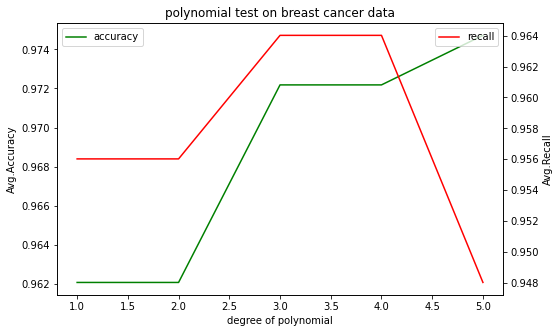

In [64]:
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(range(1,6),accuracy,color = 'g',label = 'accuracy')
ax1.set_ylabel('Avg.Accuracy')
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.plot(range(1,6),recall,color = 'r',label = 'recall')
ax2.set_ylabel('Avg.Recall')
ax2.legend(loc = 'upper right')
ax1.set(xlabel = 'degree of polynomial')
plt.title('polynomial test on breast cancer data')

3 degree is optimal in terms of accuracy and recall

In [65]:
poly_3 = PolynomialFeatures(degree = 3,include_bias=False)
X_poly_3 = poly_3.fit_transform(x_data_withoutshape)
log_clf = LogisticRegression(random_state = 42)
lr_3 = LogisticRegression(penalty = 'l1', C = 0.05, solver = 'liblinear')
lr_3.fit(X_poly_3, y_data)
cross_val_metrics(lr_3, X_poly_3, y_data)

[f1] : 0.95704 (+/- 0.02019)
[accuracy] : 0.96712 (+/- 0.02060)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.96402 (+/- 0.02023)


In [66]:
# print the selected feature and coefficient
coef = pd.DataFrame(lr_3.coef_[0],poly_3.get_feature_names(x_data_withoutshape.columns))
coef.reset_index(inplace =True)
coef.columns = ['Feature','coef']
coef.sort_values(by = 'coef',ascending= False,inplace = True)
coef = coef.loc[coef['coef']>0].reset_index(drop=True)
coef

,Feature,coef
0,BARE,0.936719
1,CLUMP^3,0.403687
2,BLAND^3,0.211817
3,NORMAL^3,0.191713
4,CELL_SIZE,0.174051
5,ADHESION^3,0.152689
6,BARE^3,0.061211
7,EPITHELIAL^3,0.051651


Text(0, 0.5, 'Coefficient')

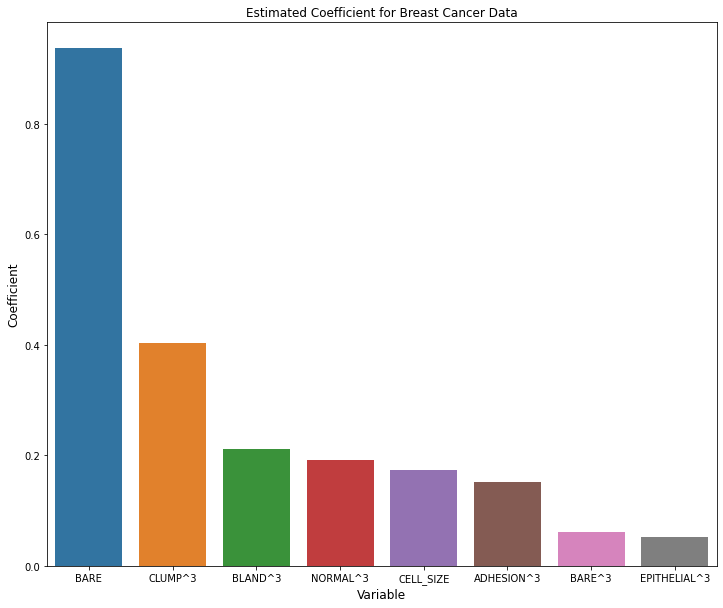

In [67]:
# visualize
variable =coef.Feature
coefficient = coef.coef
fig,(ax) = plt.subplots( figsize = (12,10))
sns.barplot(x=variable, y= coefficient, ax=ax)
ax.set_title('Estimated Coefficient for Breast Cancer Data')
ax.set_xlabel('Variable', fontsize=12)
ax.set_ylabel('Coefficient', fontsize=12)

# Ensemble model

In [68]:
#Voting Classifier
voting_clf = VotingClassifier (
        estimators = [('SVM', svm), ('knn', knn)],
                     voting='soft', weights = [1, 1])
    
voting_clf.fit(x_data_withoutshape,y_data)

y_pred = voting_clf.predict(x_data_withoutshape)
y_score = voting_clf.predict_proba(x_data_withoutshape)[:,1]

cross_val_metrics(voting_clf, x_data_withoutshape, y_data)

[f1] : 0.94300 (+/- 0.02631)
[accuracy] : 0.96206 (+/- 0.02122)
[precision] : 0.92555 (+/- 0.05530)
[recall] : 0.97027 (+/- 0.01530)


# Compare all models

In [70]:
print('SVC:')
cross_val_metrics(linear_kernel_SVM2, x_data_withoutshape, y_data)
print('Nonlinear SVM:')
cross_val_metrics(svm, x_data_withoutshape, y_data)
print('KNN:')
cross_val_metrics(knn, x_data, y_data)
print('Voting Classfier:')
cross_val_metrics(voting_clf, x_data_withoutshape, y_data)
print('Logistic Regression:')
cross_val_metrics(CV_log_clf, x_data_withoutshape, y_data)
print('Polynomial Regression with L1 regularization:')
cross_val_metrics(lr_3, X_poly_3, y_data)

SVC:
[f1] : 0.94963 (+/- 0.02157)
[accuracy] : 0.96459 (+/- 0.01864)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.95602 (+/- 0.02701)
Nonlinear SVM:
[f1] : 0.91873 (+/- 0.04679)
[accuracy] : 0.93927 (+/- 0.03530)
[precision] : 0.85779 (+/- 0.07983)
[recall] : 0.99375 (+/- 0.01250)
KNN:
[f1] : 0.95686 (+/- 0.02000)
[accuracy] : 0.96965 (+/- 0.01720)
[precision] : 0.95917 (+/- 0.03822)
[recall] : 0.95602 (+/- 0.02701)
Voting Classfier:
[f1] : 0.94627 (+/- 0.02644)
[accuracy] : 0.96206 (+/- 0.02122)
[precision] : 0.92555 (+/- 0.05530)
[recall] : 0.97027 (+/- 0.01530)
Logistic Regression:
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[f1] : 0.94927 (+/- 0.02144)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fit

Finally, compared all the cross valid results. 3rd degree polynomial L1 Regularization (C=0.05) model has relatively higher accuracy and recall value which is important to distinguish positive samples. It has smaller variation as well which means this model is more robust. What is more, we can see the parameters in the model and easily say which one is more influential. It is interpretable.

# Predict

In [71]:
# Read test data
test_data = pd.read_csv("/content/drive/MyDrive/Data/BREAST-CANCER-TESTR-W.csv")
# Drop the ID feature
test_data = test_data.drop('ID', 1)
# Print the first 5 examples
test_data.head()

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS,CLASS
0,3,1,1,1,2,2,3,1,1,
1,8,10,10,8,7,10,9,7,1,
2,5,3,3,3,2,3,4,4,1,
3,8,7,5,10,7,9,5,5,4,
4,7,4,6,4,6,1,4,3,1,


In [72]:
#Prepare test dataset
test_data = test_data.drop('CLASS', 1)
test_data = test_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
test_data['BARE'].fillna(test_data['BARE'].median(),inplace = True) # fill the space with median
test_data['BARE'] = pd.to_numeric(test_data['BARE'])

X_test = np.array(test_data.values)
# standardize the test data using defined sc
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = test_data.columns)
X_test_scaled = X_test_scaled.drop('CELL_SHAPE',1)

In [73]:
poly = PolynomialFeatures(degree = 3,include_bias=False)
x_poly = poly.fit_transform(X_test_scaled)
y_test = lr_3.predict(x_poly)
test_data['CLASS'] = y_test
test_data['CLASS'].replace(0,2,inplace = True)
test_data['CLASS'].replace(1,4,inplace = True)
test_data.to_csv('/content/drive/MyDrive/Data/BREAST-CANCER-TESTR.csv')
test_data


,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS,CLASS
0,3,1,1,1,2,2.0,3,1,1,2
1,8,10,10,8,7,10.0,9,7,1,4
2,5,3,3,3,2,3.0,4,4,1,2
3,8,7,5,10,7,9.0,5,5,4,4
4,7,4,6,4,6,1.0,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...
277,5,10,10,10,4,10.0,5,6,3,4
278,1,1,1,1,2,1.0,1,1,1,2
279,5,10,10,5,4,5.0,4,4,1,2
280,3,1,1,1,3,2.0,1,1,1,2
